# BiLSTM Model: Measuring Multi-Dimensional Hotel Quality 

This notebook walks through a deep learning model of hotel subcategroy ratings.

While aggregate reviews ratings represent a good measure of the perceived quality of a hotel, it may be useful for customers, managers, and researchers to gain a better understanding of the specific dimensions of quality. Given the importance of these finer quality dimensions, popular hotel review sites like TripAdvisor provide reviewers the opportunity to rate these quality dimensions. For instance, the example below shows that while the room appears to be in disrepair, the reviewer seems fairly happy about the service. 

![TA_screenshot](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/TA_subratings.png)


However, these additional subcategory fields are often ignored by reviewers. Nonetheless, the review text can often inform these unrated subcategories. Assuming review texts are generally informative, we can use the these texts to predict each reviewer's expected subcategory rating using deep learning methods. 

Since we have plenty of reviews with labeled subcategory ratings, we do not need to do any human labeling to construct a training dataset. Using the pre-labeled dataset, we will build a deep neural network model with embedding, bidirectional LSTM, attention, and dense layers. 

The full dataset contains over 170k locations, for demonstration purposes, we will randomly sample 200 hotels for this exercise. Using the full dataset will require some practical adjustments for the code. In particular, the code used in this notebook is designed to work in memory. Some adjustments need to be made to stream training data from disk in the case of production scale implementation. Additional hardware / cloud computing may also be required for scaling up. In particular, multi-GPU server setups and faster storage can significantly improve training speed.


*****

## Technical Specifications

**Machine specs** to generate results for this notebook.

Lenovo P520 workstation
1. 20C Xeon W processor
1. NVIDIA RTX Quadro 6000 (24GB VRAM)
1. 128 GB RAM

**Core software stack** required to run this notebook
1. Python 3.8.3 (Anaconda install, incl. pandas, numpy, etc.)
1. Tensorflow 2.1
1. NVIDIA Driver 450.119.03
1. CUDA 10.1
1. CuDNN 7.6.5

**Additional required** software for preprocessing
1. Spacy 3.0.5, GPU enabled (standard small English model)
1. Gensim 4.0.1
1. NLTK 3.5 (just for stopwords - should download them)

**Optional software** for running code (slight adjustments needed if not used)
1. progressbar 3.53.1
1. pandarallel 1.5.2

# Import libraries

In [1]:
# standard imports (installed by default w/ anaconda)
import pandas as pd, numpy as np, os,random, matplotlib.pyplot as plt,gc
from itertools import chain
from collections import Counter
%matplotlib inline

# Tensorflow for GPU-enabled deep learning 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping

print(tf.test.is_gpu_available()) # GPU enabled?


### Needed only for processing raw data (not necessary, skip to Creating a prediciton model)
import progressbar # don't need this if progress tracking on loops is not needed
from pandarallel import pandarallel # don't need this if no parallel processing is desired on pandas dataframes
# change .parallel_apply to .apply
pandarallel.initialize(nb_workers=5)
# Imports for NLP
import spacy
from nltk.corpus import stopwords
sw = stopwords.words('english')
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/yang/anaconda3/envs/gpu/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Raw Files

In [2]:
# Figure out what data we have
# This data was collected with coauthor Alex Chaudhry from 2017-2018 (see Wang & Chaudhry, 2018 JMR paper for data details), contains

flist = list()
for root,sub,files in os.walk('/mnt/data2/tripadvisor/New_Review_Data2/scrape_4'):
    files = [f for f in files if '.txt' in f]
    if len(files)>0:
        flist.append(['/'.join([root,f]) for f in files])
flist = list(chain(*flist))

print('Total Venues: {}'.format(len(flist)))

Total Venues: 176095


In [3]:
# ignore predominantly foreign language files
flist = [f for f in flist if 'lang_detect' not in f] 
# Get a sample of files:
random.seed(1)
samplesize = 200 # number of hotels
flist = random.sample(flist, samplesize) # Sample some files

# Preprocess texts


While not the focus of this notebook, this step can be crucial for the successful application of deep learning NLP models. Some basic elements of pre-processing include:

1. Normalization: lemmatize, remove stop words (uninformative words like articles)
1. Phrase modeling: combine words that appear together frequently into phrases. This step can greatly improve custom trained models but will be unnecessary if using pre-trained NLP models like BERT as a starting point. There's a tradeoff here between the value of massive training scale of pre-trained models versus context-specific domain knowledge that can be captured by context-specific phrases.
1. Tokenizing: map remaining words and phrases to integer IDs, filter out infrequent words (probably misspellings or proper nouns) and frequent words (uninformative words). The filtering is less necessary with more sophisticated models and big data.

Some additional steps we take in this section include removing non-English reviews, removing punctuation, and de-casing.

In [4]:
# Construct dataset form individual CSV's
data = list()
for f in progressbar.progressbar(flist):
    df = pd.read_csv(f, encoding = 'utf-8', sep = '|', index_col = 0)
    if 'review_subratings' in df.columns.values:
        df.review_subratings = df.review_subratings.map(eval)
        subratings = list(set(chain(*df.review_subratings.apply(lambda x: x.keys()))))
        for r in subratings:
            df['r_{}'.format(r.lower().replace(' ', '_').replace('/','').split('(')[0].replace('__','_'))] = df.review_subratings.apply(lambda x: x.get(r))
        cols = ['r_{}'.format(r.lower().replace(' ', '_').replace('/','').split('(')[0].replace('__','_')) for r in subratings]
        df = df[['gd', 'review_id', 'review_date','review_rating', 'review_text']+cols]
        df = df[df.review_text.notnull()]
        data.append(df)
data = pd.concat(data).reset_index(drop = True)
del df

100% (200 of 200) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [5]:
# Get rid of non-English reviews by detecting the proportion of English stop words in the review
sws = set([w for w in sw if len(w)>2])
nwrds = len(sws)
data['stopwords'] = data.review_text.parallel_apply(lambda x: len([w for w in x.strip().split() if w in sws]))
data['reviewlen'] = data.review_text.str.strip().str.split().map(len)
data['stopword_pct'] = data.stopwords/data.reviewlen

<AxesSubplot:>

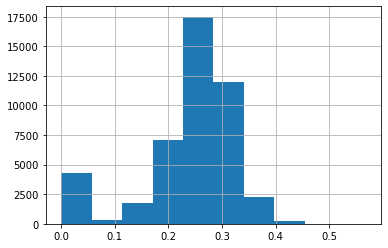

In [6]:
# Second peak below .1, get rid of all those, likely non-english.
# In my experience, .1 seems like the norm.
data.stopword_pct.hist() 

In [7]:
# Just check to see that these appear to be mostly non-English
data[data.stopword_pct<.1] .sample(10)['review_text']

41891    Ci tornerei in questo piccolo hotel. Personale...
28395    Great stay! Nice modern"ish room, lovely bayfr...
2290     Lo positivo:La ubicación de los apartamentos e...
32885    Estuvimos 5 días en familia y el complejo se e...
21298    ...aber sehr liebevoll. Das dies kein "Hotel" ...
21922    Servono tre lettere per descriverlo:wow!Vasca ...
19674    Sehr nettes Restaurant mit einer guten Weinkar...
4474     Villaggio nel complesso molto grande ed esteso...
2321     Nous avons passé une très bonne semaine à la d...
4703     Abbiamo soggiornato dal 14 al 21 agosto 2012. ...
Name: review_text, dtype: object

In [8]:
data = data[data.stopword_pct>.1] # keep only English

In [9]:
data.review_text.sample(10) # English!

25158    I have stayed at a lot of hotels in Minn. and ...
27099    We stayed at Fairmont Princess for 6 nights an...
30005    Excellent hotel! the free shuttle is easy and ...
1697     i have had alot of operations in the past few ...
12854    We sprang for the club floor and were glad we ...
5572     Stayed here but go self catering. Plenty of pl...
18889    First, to see northern lights either stay in t...
17391    Beautiful hotel, great food, waiters were nice...
12074    Grand Hyatt Kauai really exceeded my expectati...
33670    The rooms are beautiful and very clean, the pr...
Name: review_text, dtype: object

## Lemmatization

We use Spacy to do lemmatization. Spacy preloads state of the art deep-learning English parsing models. These can be run using GPU. Alternative methods such as rule-based stemming can be executed much faster, see NLTK stemming methods.

In [10]:
spacy.require_gpu() # use GPU for faster computation
nlp = spacy.load('en_core_web_sm') # using full transformer based models (better accuracy)

In [11]:
texts = list(data.review_text)

In [12]:
# Lemmatize - this may take a while (couple of minutes)
# A faster, but less accurate alternative is to use stemming methods (see NLTK lemmatizers)
lemma = [[[w.lemma_.strip().lower() for w in s if not w.is_punct] for s in nlp(t).sents] for t in texts]
del nlp
gc.collect() # make sure nlp cleared from memory, may be unnecessary

81417

## Phrase modeling 

We use Gensim to do co-location phrase modeling. In essence, any 2 words that appear next to each other more than K times than would be expected at random given empirical frequencies of words will be tagged as a phrase. Usually, we use K=10. Note that we run phrase modeling twice, the first pass detects phrases of 2 words, the second pass can detect phrases consisting of up to 4 words.

In [13]:
# Lemmatized sentences
sentences = list(chain(*lemma))

In [14]:
# Model phrases using colocation frequency >10x random
phrase_model = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
sentences2 = phrase_model[sentences]

In [15]:
# run again for longer sequences
phrase_model2 = Phrases(sentences2, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
sentences3 = phrase_model2[sentences2]

In [16]:
sentences3[55] # look at a review w/ phrases

['the', 'library', 'have', 'these', 'great', 'back', 'pack', 'for', 'kid']

In [17]:
# get parsed documents - previously we had sentences
parsed = [list(phrase_model2[phrase_model[l]]) for l in lemma] 

In [18]:
# remove stopwords
parsed = [[[w for w in s if w not in sw] for s in p] for p in parsed] 

In [19]:
# Create new column for processed reviews in dataframe
data['processed_reviews'] = [' '.join(list(chain(*p))) for p in parsed] # Get text as single str

In [20]:
# processed text looks like this
data.processed_reviews[0] 

'immaculate neighbor rarely hear beautiful location lot tree foliage unit recently remodel beautiful washer_and_dryer also include unit post picture take later'

In [21]:
# Max text length this is the distribution of review length (based on processed text)
# We can use this to inform us of the input length into the deep learning model
data['processed_len'] = data.processed_reviews.str.split().map(len)

<AxesSubplot:>

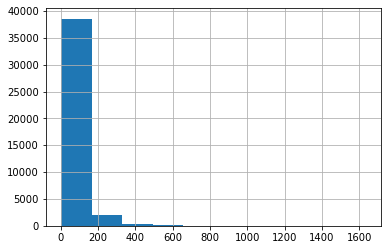

In [22]:
data.processed_len.hist()

## Standardize vocab (remove extremes)

In [23]:
# Get vocab 
vocab = Counter(chain(*data.processed_reviews.str.strip().str.lower().str.split()))
V = pd.DataFrame(vocab.items(), columns = ['w', 'ct'])
V['logct'] = np.log(V.ct)

<AxesSubplot:>

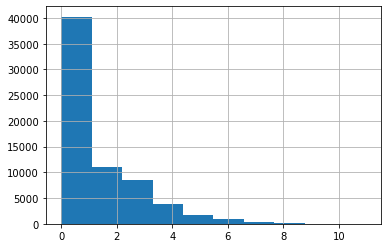

In [24]:
# log count distribution of each token
# We can cut off words that appear too frequently
V.logct.hist()

In [25]:
# Filter out words
remove = set(V.loc[(V.ct<20)|(V.logct>10), 'w'])
len(remove)

58021

In [26]:
data['processed_review_filter'] = data.processed_reviews.parallel_apply(lambda x: ' ' .join([w for w in x.strip().lower().split() if w not in remove]))

# Construct and Visualize a BiLSTM model for mapping text to ratings

## Read in processed data

In [1]:
# Save/Load preprocessed reviews
if 1==0: # if running pre processing, set 1==1
    data.to_csv('tripadvisor.csv', encoding = 'utf-8')
if 1==1: # if using processed texts, set 1==1
    data = pd.read_csv('tripadvisor.csv', encoding = 'utf-8', index_col = 0)
    data = data[data.processed_review_filter.notnull()]
data.columns.values

array(['gd', 'review_id', 'review_date', 'review_rating', 'review_text',
       'r_cleanliness', 'r_rooms', 'r_value', 'r_service',
       'r_sleep_quality', 'r_check_in_front_desk', 'r_business_service_',
       'r_location', 'stopwords', 'reviewlen', 'stopword_pct',
       'processed_reviews', 'processed_len', 'processed_review_filter'],
      dtype=object)

In [28]:
# Length of vocabulary
data['processed_review_filter'] = data['processed_review_filter']
vocab = set(chain(*data.processed_review_filter.str.split()))
len(vocab) # Vocab size

8727

In [2]:
# this is what the data looks like:
data.head()

,gd,review_id,review_date,review_rating,review_text,r_cleanliness,r_rooms,r_value,r_service,r_sleep_quality,r_check_in_front_desk,r_business_service_,r_location,stopwords,reviewlen,stopword_pct,processed_reviews,processed_len,processed_review_filter
0,g31587-d242287,556361970,2018-01-25,5.0,"Immaculate, we had some neighbors, but rarely ...",NaN,5.0,NaN,5.0,NaN,NaN,NaN,5.0,12,45,0.266667,immaculate neighbor rarely hear beautiful loca...,21,immaculate neighbor rarely hear beautiful lot ...
1,g31587-d242287,553666229,2018-01-13,5.0,From the time we checked in on Dec 30 @845pm. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67,299,0.224080,time check dec 30 @845pm staff friendly_and_he...,145,check dec 30 friendly_and_helpful feel right c...
2,g31587-d242287,550530443,2017-12-31,5.0,We stayed in the Fairways condos. Very clean a...,5.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,13,69,0.188406,stay fairways condo clean comfortable 2_bdrm g...,32,condo comfortable 11 15 yr_old 3_night hike ma...
3,g31587-d242287,544078845,2017-11-29,5.0,We rented a 2BR condo this through RCI for Tha...,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,144,611,0.235679,rent 2br condo through_rci thanksgiving week g...,281,rent condo thanksgiving week kid 13 11 6 first...
4,g31587-d242287,542414023,2017-11-21,5.0,From the time you walk through the door at the...,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,24,87,0.275862,time walk_through door registration office fee...,35,walk_through door registration office feeling ...


## Define model architecture

Our model will consist of the following **core concepts** from deep learning.

1. [Embedding](https://en.wikipedia.org/wiki/Word_embedding)
1. [RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network) / [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
1. [Attention](https://en.wikipedia.org/wiki/Attention_(machine_learning))
1. [Dense network with nonlinearities](https://medium.com/datathings/dense-layers-explained-in-a-simple-way-62fe1db0ed75)
1. [Dropout](https://en.wikipedia.org/wiki/Dilution_(neural_networks))
1. [Loss function](https://en.wikipedia.org/wiki/Loss_function)

### Embedding



Embedding is a powerful concept in ML, particularly for NLP. The basic idea is to take a high dimensional variable and represent them in a lower dimensional space. In NLP, we think of the high dimensional variable as the words contianed in a vocabulary. A typical way to convert text to numerical data is to one-hot-encode (aka dummy code) the text. However, it may become computationally infeasible and also inefficient from a learning perspective to represent each word as an independent and unique factor. Therefore, rather than representing each of 10k words in a vocabulary, for example, as a 10k-dimensional vector with 9999 0's and a single 1, we can represent each word as being a vector in a lower dimensional space. For instance, from our model's embedding representation, each word will occupy a 128-D space. Here's an example of a few words and the first 5 dimensions:

![Embedding example](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/embedding_matrix.png)

By embedding a one-hot-encoded space into a lower dimensional space, we are implicitly specifying that some words are close together than others in "meaning." From an NLP perspective, this is very natural. The words "hotel" and "motel," for example, are much more similar to each other than "hotel" and "restaurant." Thinking beyond NLP, one can imagine the application to representing individual customer IDs as being embedded in a lower dimensional space - some customers are more alike than others (heterogeneity! targeting!).

There is an important decision when using embedding in a neural network. Should we **train our own embedding** or **use pre-trained embeddings**? Pre-trained embeddings can reduce training time and allow you to leverage massive secondary datasets (wiki/common crawl). However, these embeddings are trained on general rather than context-specific documents and do not allow you to pre-process the text with domain-specific knowledge in mind. We can also train our own embeddings, but even this can be generally done in 2 ways. First, we can train an embedding using an unsupervised method, like [word2vec](https://en.wikipedia.org/wiki/Word2vec). Such an embedding model depends only on the sequence of words and the structure of sentences within documents, and not outcome labels. If we do not have much labeled data, we can use a full text corpous to conduct this type of embedding training and use the results as inputs to a prediction model applied on the smaller labeled dataset. Alternatively, with a sufficient number of labeled observations, we can train our own embedding layer as part of a larger end-to-end deep learning model that has an objective of accurately predicting an outcome, i.e. training a purpose built embedding layer. In our case, we will demonstrate how to incorporate this last type of embedding.


Since our embedding layer is designed to embed vocabulary into a lower dimensional space *that best predicts subcategory ratings*, **we will have very different embeddings depending on the dependent variable used to train** the model:

**Service quality word embeddings** 

Most "similar" words for "helpful"
![service embedding: helpful](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/service_embed_helpful.png)

Most "similar" words for "rude"
![service embedding: rude](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/service_embed_rude.png)

**Room quality word embeddings**
Clearly, helpful and rude don't reference rooms, but they are correlated with certain room characteristics. Thus, the **embeddings here are less intuitive**.

Most "similar" words for "helpful"
![service embedding: helpful](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/room_embed_helpful.png)

Most "similar" words for "rude"
![service embedding: rude](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/room_embed_rude.png)

**However**, if we use room-relevant words, the embeddings make some more sense.

Most "similar" words for "dirty"
![service embedding: rude](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/room_embed_dirty.png)

Most "similar" words for "view"
![service embedding: rude](https://yangwangresearch.s3-us-west-2.amazonaws.com/NLP_Images/room_embed_view.png)



### RNN/LSTM

LSTM (long short-term memory) is a specific (and popular) type of RNN (recurrent neural network). The idea of both is to take temporal sequences into account in predictive models. In the context of NLP, the sequence of words matter above and beyond their inclusion in a document (think [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation). For example, *"this old hotel's front desk employees are excellent"* is very different compared to "hotel's old front desk employees are excellent." Thus the relative locations of words in a text is absolutely critical to the correct understanding of the text.

RNN generally model temporal dependencies by allowing past observations to pass information into subsequent observations. In the illustration below, each observation $x_t$ feeds into an RNN cell in which some operation $V$ is computed and passes some information $h_t$ into the next observation in a temporal sequence while outputting $O_t$ for the current time step.

![RNN from wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2880px-Recurrent_neural_network_unfold.svg.png)

LSTM ([Hochreiter and Schmidhuber, 1997](http://www.bioinf.jku.at/publications/older/2604.pdf)) is a specific variant of RNN that has a more complex cell structure incorporating input, output, and forgetting gates. The design of LSTM is to allow for the network structure to learn from not only the most recent information (RNN's structure biases towards "recent" cells), but also context from earlier observations. This is especially important for NLP problems where information from an earlier part of the document provides the context for the machine to understand the meaning of a focal word. The figure below illustrates these the inner workings of an LSTM cell. The core idea of the LSTM modification of a vanilla RNN is visualized in the top horizontal line that goes through the cell and connects to the subsequent cell (the output of this is frequently denoted as $C_t$). This route of passing information is designed to have minimal interaction with the nonlinear operations within the cell. New information gets incorprated at two key points. First, a sigmoid ($\sigma$) activation layer acts as a gate to allow certain information from the current $X_t$ through. Second, the $tanh$ activation creates a vector of new candidate values bounded between -1 and 1 that could be propagated to the next state. To determine if this vector is passed down, a second $\sigma$ gate will generate 0's or 1's to multiply to the candidate values. The product of these 2 are then added to the updated long term information route. Finally, to pass on the "short term" $h_t$, we multiply the prior $\sigma$-gated $h_{t-1}$ with a $tanh$-activated $C_t$ to determine $h_{t+1}$.

In short, there are 2 routes for information to be transferred. A **long memory route** that sometimes incorporates new information and a **short memory route** that primarily passes down newer information, hence "long short-term memory." For our problem, we actually run the LSTM forwards and backwards to achieve better performance, this is called [bidirectional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) LSTM and is a staple of modern NLP models.

![LSTM from colah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
[Borrowed from Chris Olah, *Google Brain*](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### Attention 


Not to be outdone by the success of LSTM, attention mechanisms have become a mainstay in the world of deep learning, particularly for NLP. The idea behind attention is incredibly simple (though there are variants with more complicated details). Typically in a ML model, only the final output from the last LSTM cell is propagated forward, since it encapsulates a summary of all the prior information. Attention layers allow all the intermediate outputs of each LSTM cell to be used in a "smart" way by weighting them (think weighted average). In practice, the weights typically pass through a network structure, like a $tanh$ activation fed into a softmax (logit probability weights) before combining with the sequential layer (lstm) outputs as a dot product. The end output from the attention layer, known as a "context" vector, is fed forward to the rest of the deep learning model. The illustration below from Matthew McAteer demonstrates how an bi-LSTM model can be used in conjunction with a global attention layer to improve a binary classification task. Note that for our task, we will solve a regression (not classification) problem


![attention McAteer](https://matthewmcateer.me/media/attention/additive_attention.png)
*borrowed from [Matthew McAteer](https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/)*




### Dense layers, nonlinear activation, dropout, Loss

In our model, our attention context layer feeds in to one more fully connected hidden layer to reduce the attention dimensionality. A fully connected dense layer is often used to flexibly fit curves, particulary when combined with a simple nonlinear activation, such as ReLU (recitified linear unit). ReLu takes inputs and transforms them by converting all negative values to 0. This forced nonlinearity helps dense networks adapt to arbitrary functional forms. This presents an additional problem, overfitting (see illustration below). The problem with overfitting is that the model begins to memorize the training data than extracting systematic relationships that can be generalized to another dataset. There are many ways to combat this problem (e.g. adding L1/L2 penalties), but one that is almost always present with fully connected layers is dropout. Dropout works by randomly dropping nodes in a layer for robust training (output not significantly impacted by node omission). In this way, the network becomes more robust as weights per node are not over emphasized in training.

![Medium Overfitting](https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png)
From [Anup Bhande](https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76)

Our model, laid out in code below, combines all the previously covered core topics in deep learning. We begin with an embedding layer, which feeds into a BiLSTM layer, which feeds into an attention layer, which feeds into a dense layer, which outputs to a single scalar, the predicted rating based on the review text input. To train a ML model, we need one more component, an objective on which to optimize, i.e. a loss function. Given our problem is to predict a continuous variable, we will be using a mean squared error loss (just like OLS). Based on changes to this loss objective as a consequence of small adjustments to each of the trainable weights in our model (taking iterative derivatives from the last to first layer, i.e. back-propagation), we can finally train the model for our prediction task.

In [29]:
# Define Attention Layer
# Basically a weighted average layer over RNN sequence
# where weights are learned in training
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    

In [132]:
# Function to define full model
def bilstm_attention_model(MAX_FEATURES=9000,MAX_LEN=300,EMBED_SIZE=128,RNN_CELL_SIZE=32, ATTEN_SIZE=10,DENSE_SIZE=54, DROPOUT=.1):
    sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
    embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

    # Bidirectional LSTM
    lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), 
                         name="bi_lstm_0")(embedded_sequences)

    # Getting our LSTM outputs
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, 
                                                                              return_sequences=True, 
                                                                              return_state=True), 
                                                                         name="bi_lstm_1")(lstm)
    
    
    # Given bi-directional RNN, must concatenate the forward+ backward hidden states from each RNN 
    # before computing the attention weights and applying the weighted sum.
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention(ATTEN_SIZE)(lstm, state_h) # attention weighted output
    dense = Dense(int(DENSE_SIZE), activation="relu")(context_vector)
    dropout = Dropout(DROPOUT)(dense)
    output = Dense(1, activation="relu")(dropout)
    model = tf.keras.Model(inputs=sequence_input, outputs=output)
    return model

In [201]:
# Parameters of model (can change these - choice is a bit of an art)
# We define them here just to print out the schematic below
# these parameters can be optimally selected by doing a grid search, but in practice, this is not so practical 


EMBED_SIZE = 128
  
RNN_CELL_SIZE = 24
  
MAX_LEN = 300

ATTEN_SIZE = 32

DENSE_SIZE = 16

DROPOUT = .25


tokenizer = Tokenizer(num_words=None, filters = '', oov_token = 'OOV') # Create integer coding of vocab size
tokenizer.fit_on_texts(data['processed_review_filter']) # Make text to sequence mapping

MAX_FEATURES = len(tokenizer.word_index)

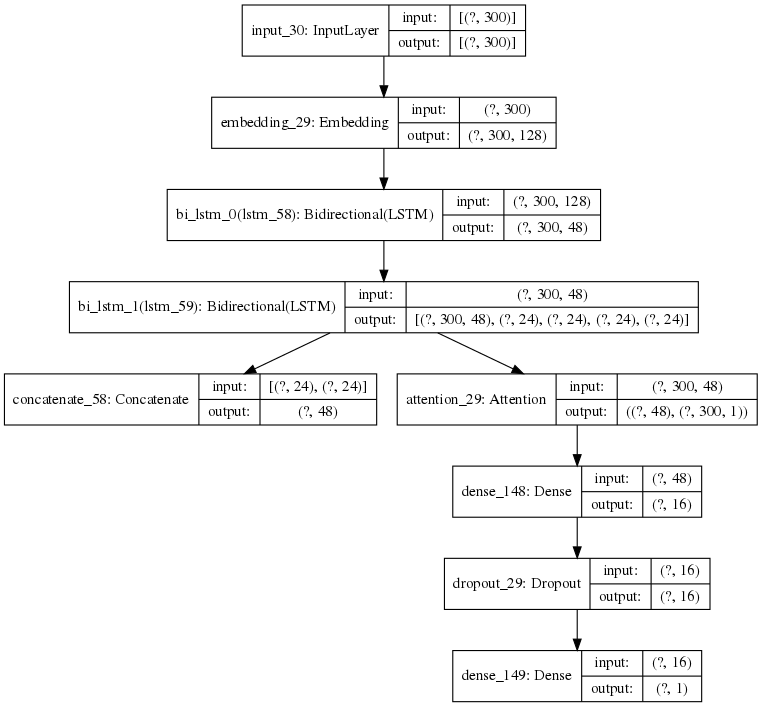

In [202]:
model = bilstm_attention_model(MAX_FEATURES+1,
                               MAX_LEN,
                               EMBED_SIZE,
                               RNN_CELL_SIZE, 
                               ATTEN_SIZE,
                               DENSE_SIZE, 
                               DROPOUT=DROPOUT)




# Print out model schematic
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)


## Training



Training can also be a bit of an art. In this example, we specify some of the following common training hyperparameters/adjustments:

1. Sample split (training, validation, testing)
1. Validation
1. Early stopping criteria + patience

Sample split is a fundamental idea in ML. By separating a dataset into training, validation, and testing sets, we can optimize training and evaluate the results out of sample. Validation set is used to evaluate training performance, particularly to stop training when the out of sample predictions stop improving. We implement this for training our model.

In [203]:
# Full dataset predictors, this will be used to predict back on full dataset after training
list_tokenized_train = tokenizer.texts_to_sequences(data.loc[:,'processed_review_filter']) # 
X_all =  pad_sequences(list_tokenized_train, maxlen=MAX_LEN)

In [204]:
X_all[:10] # sequences of token ID's in column space, 1 row = 1 review

array([[   0,    0,    0, ...,  523,   32,  401],
       [   0,    0,    0, ...,  214, 6372,  205],
       [   0,    0,    0, ...,    2,  199,  906],
       ...,
       [   0,    0,    0, ..., 2503,  718,   24],
       [   0,    0,    0, ...,  855,  509,   55],
       [   0,    0,    0, ...,  272,  194,    2]], dtype=int32)

In [205]:
BATCH_SIZE = 200 # number to train in a batch, smaller = more stable training, but slower
EPOCHS = 100 # complete cycles through training data

np.random.seed(1) # seed for reproducible results
data['train'] = np.random.binomial(1,.75, size =len(data)) # Randomly assign 15% to testing set
data.loc[data.train==0,'train'] = np.random.binomial(1,.5,size = sum(data.train==0))-1

# DVs = [c for c in data.columns if ('r_'==c[:2])&('_pred' not in c)]# train for these DVs

DVs = ['r_service', 'r_rooms', 'r_value', 'r_location']

training_histories = list()
for dv in DVs:
    
    cond = (data[dv].notnull())&(data['train']==1) # subset condition for training
    
    # Tokenize the text (convert to list of IDs)
    list_tokenized_train = tokenizer.texts_to_sequences(data.loc[cond,'processed_review_filter'])
    
    # 0 Pad the tokenized data
    X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)

    # Select corresponding training labels
    y_train = data.loc[cond,dv]
    
    condval = (data[dv].notnull())&(data['train']==-1)
    # Tokenize the text (convert to list of IDs)
    list_tokenized_val = tokenizer.texts_to_sequences(data.loc[condval,'processed_review_filter'])
    
    # 0 Pad the tokenized data
    X_val = pad_sequences(list_tokenized_val, maxlen=MAX_LEN)

    # Select corresponding training labels
    y_val = data.loc[condval,dv]
    
    # define model
    model = bilstm_attention_model(MAX_FEATURES + 1, # Add 1 feature for 0 padding
                                   MAX_LEN,
                                   EMBED_SIZE,
                                   RNN_CELL_SIZE, 
                                   ATTEN_SIZE,
                                   DENSE_SIZE, 
                                   DROPOUT=DROPOUT)
    
    
    # compile model to maximize mean squared error, use adaptive optimizer
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=.01))
    
    # Train
    history = model.fit(X_train,y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_val, y_val),
                       callbacks = [EarlyStopping(patience=10, restore_best_weights=True)])
    
    training_histories.append(history)
    
    # Save model in Models subfoler, make it if it doesn't exist
    try:
        os.listdir('./models/')
    except:
        os.mkdir('./models/')
        
    # Save model
    model.save_weights('./models/bilstm_attention_{}.h5'.format(dv))
    
    
    # predict back on dataset
    data[dv+'_pred'] = model.predict(X_all)
    
    del model
    gc.collect()

Epoch 1/100
122/122 [==============================] - 11s 92ms/step - loss: 2.0047 - val_loss: 0.6612
Epoch 2/100
122/122 [==============================] - 10s 86ms/step - loss: 1.2184 - val_loss: 0.7187
Epoch 3/100
122/122 [==============================] - 10s 86ms/step - loss: 0.9457 - val_loss: 0.5338
Epoch 4/100
122/122 [==============================] - 10s 86ms/step - loss: 0.7434 - val_loss: 0.5566
Epoch 5/100
122/122 [==============================] - 10s 86ms/step - loss: 0.5685 - val_loss: 0.5752
Epoch 6/100
122/122 [==============================] - 10s 86ms/step - loss: 0.4466 - val_loss: 0.6025
Epoch 7/100
122/122 [==============================] - 10s 86ms/step - loss: 0.3581 - val_loss: 0.5865
Epoch 8/100
122/122 [==============================] - 10s 86ms/step - loss: 0.2909 - val_loss: 0.5945
Epoch 9/100
122/122 [==============================] - 10s 86ms/step - loss: 0.2370 - val_loss: 0.6039
Epoch 10/100
122/122 [==============================] - 10s 86ms/step - l

# Diagnostics

## Training / Validation / Testing $R^2$

In [206]:
def mse(ytrue,ypred):
    return np.nanmean((ytrue-ypred)**2)

def r2(ytrue,ypred):
    SSR = mse(ytrue,ypred)
    SST = np.nanmean((ytrue-np.nanmean(ytrue))**2)
    return 1-SSR/SST

In [207]:
r2train = np.array([r2(data.loc[data.train ==1,c],data.loc[data.train==1,c+'_pred']) for c in DVs])
r2train = pd.DataFrame(list(zip(DVs, r2train)), columns = ['dv','r2'])
print('Training R2')
r2train # note that location often does not require text to justify

Training R2


,dv,r2
0,r_service,0.708894
1,r_rooms,0.727312
2,r_value,0.634327
3,r_location,0.687937


In [208]:
r2test = np.array([r2(data.loc[data.train ==-1,c],data.loc[data.train==-1,c+'_pred']) for c in DVs])
r2test = pd.DataFrame(list(zip(DVs, r2test)), columns = ['dv','r2'])
print('Validation Sample R2')
r2test

Validation Sample R2


,dv,r2
0,r_service,0.510500
1,r_rooms,0.445017
2,r_value,0.418473
3,r_location,0.158495


In [209]:
r2test = np.array([r2(data.loc[data.train ==0,c],data.loc[data.train==0,c+'_pred']) for c in DVs])
r2test = pd.DataFrame(list(zip(DVs, r2test)), columns = ['dv','r2'])
print('Out of Sample R2')
r2test

Out of Sample R2


,dv,r2
0,r_service,0.501303
1,r_rooms,0.439594
2,r_value,0.429691
3,r_location,0.188424


## Training / Validation / Testing Predicted vs. Actual Ratings

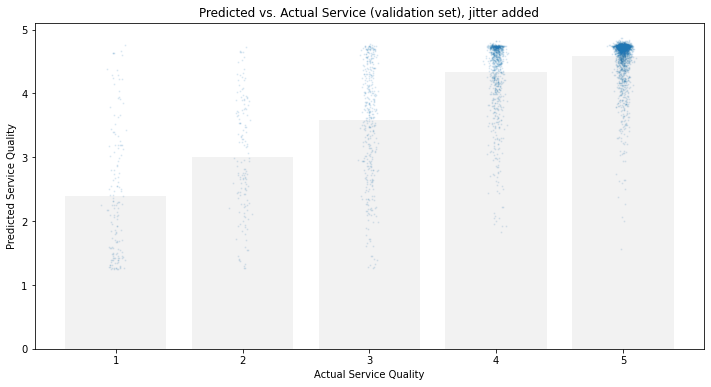

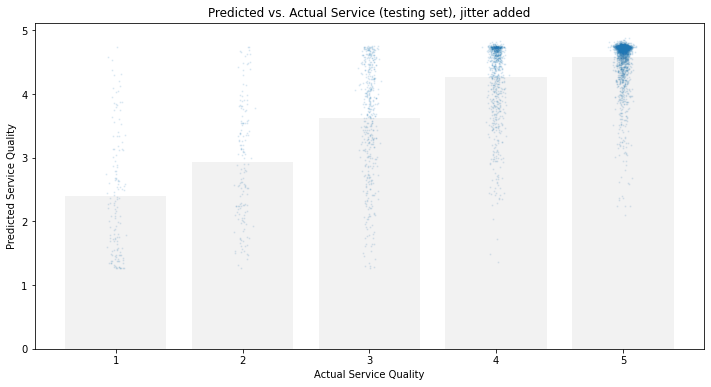

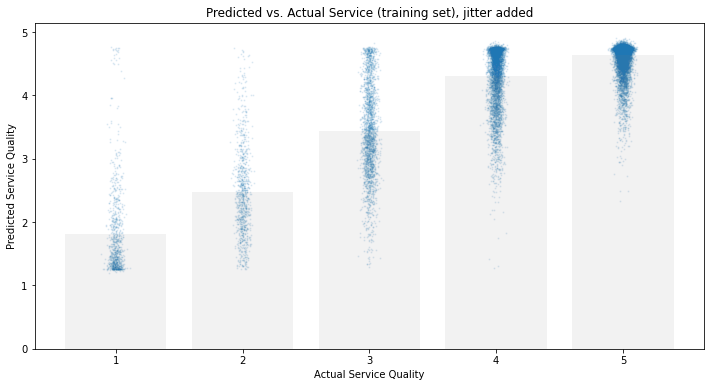

In [210]:
training = ['validation', 'testing','training']
for i in range(3):
    fig,ax = plt.subplots(1, figsize=(12,6))
    T = i-1
    temp = data[data.train==T].groupby('r_service')['r_service_pred'].mean()
    ax.bar(temp.index.values, temp, alpha = .1, color = 'gray')
    ax.scatter(data.loc[data.train==T, 'r_service']+np.random.normal(0,.03, size = sum(data.train==T)),
                data.loc[data.train==T, 'r_service_pred'], alpha = .1, s=1,zorder = 1)
    ax.set_title('Predicted vs. Actual Service ({} set), jitter added'.format(training[i]))
    ax.set_xlabel('Actual Service Quality')
    ax.set_ylabel('Predicted Service Quality')



## Use trained model to examine a review text example

In [211]:
# pick a review
r = data[(data.processed_review_filter.apply(lambda x: 'curious helpful' in x))].iloc[0]
txt = r.review_text # example
txt

'This needs major refurbishing, carpets, curtains, updated bathrooms decor. Security locks broken on outside security doors. Employees are very curious and helpful'

In [212]:
# service and rooms ratings for this review
r[DVs[:2]+[d+'_pred' for d in DVs[:2]]]

r_service               4
r_rooms                 1
r_service_pred     3.6424
r_rooms_pred      1.44055
Name: 419, dtype: object

### What embeddings looks like

In [219]:
# Get tokenized review
txt = r.processed_review_filter
list_token = tokenizer.texts_to_sequences([txt])
X_example = pad_sequences(list_token, maxlen=MAX_LEN)

# Construct model that outputs embedding layer
model = Model(inputs=model_service.input,
              outputs=[model_service.output, model_service.layers[1].output])

# Get embeddings
embed = model(X_example)[1].numpy()[:,-len(r.processed_review_filter.split()):,:]
embed = pd.DataFrame(embed.reshape(embed.shape[1],-1))
embed['w'] = r.processed_review_filter.split()
embed = embed.set_index('w').reset_index()

In [220]:
embed # this is what the embedded sentence looks like

,w,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,need,-0.153277,0.151049,0.049563,0.005724,-0.281003,0.039933,0.116026,0.030078,-0.024215,...,-0.153277,0.014198,-0.228280,0.047854,-0.089114,0.038555,0.213016,-0.341551,-0.012967,0.001896
1,major,0.048864,0.170309,-0.091371,-0.051421,-0.126080,-0.056660,0.118470,-0.097470,-0.077731,...,-0.006660,-0.010731,-0.260449,-0.105582,0.021848,0.051685,-0.048613,-0.263173,-0.058572,0.194312
2,carpet,0.037575,0.274496,-0.076754,-0.225906,0.010641,0.167724,0.117246,-0.328181,0.119915,...,0.099799,0.045327,-0.266834,-0.024726,-0.008895,-0.058412,0.029815,-0.265493,-0.169545,0.037877
3,curtain,0.160241,0.326806,-0.263795,-0.255988,-0.343599,-0.274087,0.218184,-0.271549,-0.123203,...,-0.220831,-0.150689,-0.231832,-0.192851,0.309888,0.242962,-0.089342,-0.323026,-0.276566,0.084744
4,update,-0.124054,0.023317,0.065383,0.158645,-0.065012,0.037106,-0.076911,0.143909,0.006019,...,-0.050611,0.044046,-0.109570,0.085027,-0.016025,0.043716,0.128514,-0.144048,-0.067072,0.067050
5,bathroom,-0.001828,0.255573,-0.085653,-0.120211,-0.296158,-0.053014,0.055130,-0.262974,0.078518,...,-0.223451,-0.080461,-0.232065,-0.012175,0.101244,0.054207,-0.008718,-0.286355,-0.177458,0.123361
6,decor,-0.065441,0.146884,-0.029185,0.029604,-0.076079,-0.155165,0.008318,0.000991,-0.064184,...,-0.213783,-0.121507,-0.246935,-0.233755,0.126129,0.258441,-0.015208,-0.332384,-0.057919,0.107391
7,security,0.150631,0.167116,-0.118544,-0.229363,-0.171779,-0.221081,0.259167,-0.165931,-0.111651,...,-0.153325,-0.290101,-0.202344,-0.063207,0.244712,0.235543,-0.192106,-0.293393,-0.144666,0.083223
8,lock,0.136257,0.151273,-0.191549,-0.334461,-0.237539,-0.067312,0.133114,-0.224572,-0.058581,...,-0.244534,-0.295077,-0.336320,0.036913,0.356542,0.463846,-0.153174,-0.295808,-0.540657,0.095671
9,break,-0.023993,0.103559,-0.166736,-0.146084,-0.102323,-0.086234,-0.033532,-0.054762,-0.100589,...,-0.180171,0.000193,-0.155325,-0.105210,0.124581,0.386774,-0.016124,-0.187542,-0.251992,0.113575


In [221]:
# use to compute similarity
from sklearn.metrics.pairwise import cosine_similarity

# retrieve index for each word
wordindex = pd.DataFrame(tokenizer.word_index.items(), columns = ['w', 'id'])

# Retrieve embedding weights from service model
embedwts = pd.DataFrame(model_service.layers[1].get_weights()[0])
embedwts['id'] = embedwts.index.values

# merge word:index with index:embedding
wordindex = wordindex.merge(embedwts, how = 'left', on = 'id')

# Similarity matrix, remember this is similarity w.r.t. how similar
# the words are in their ability to predict service quality
simmatrix = pd.DataFrame(cosine_similarity(np.array(wordindex[list(range(EMBED_SIZE))])))
simmatrix.index = wordindex.w
simmatrix.columns = wordindex.w

In [222]:
# most "similar" to helpful
simmatrix['helpful'].sort_values(ascending = False).head(10)

w
helpful                      1.000000
wonderful                    0.951756
excellent                    0.950727
easy                         0.946147
conveniently_locate          0.939649
spice                        0.938634
22nd                         0.936050
very_friendly_and_helpful    0.931041
best                         0.930881
russian_guest                0.930526
Name: helpful, dtype: float32

In [223]:
# most "similar" to rude
simmatrix['rude'].sort_values(ascending = False).head(10)

w
rude                    1.000000
indifferent             0.965205
zero                    0.964413
totally_unacceptable    0.963160
useless                 0.959357
no_apology              0.959173
unhelpful               0.958967
argue                   0.957434
turn_into               0.957403
spider                  0.956066
Name: rude, dtype: float32

In [224]:
# let's do the same thing for rooms
# retrieve index for each word
wordindex = pd.DataFrame(tokenizer.word_index.items(), columns = ['w', 'id'])

# Retrieve embedding weights from service model
embedwts = pd.DataFrame(model_rooms.layers[1].get_weights()[0])
embedwts['id'] = embedwts.index.values

# merge word:index with index:embedding
wordindex = wordindex.merge(embedwts, how = 'left', on = 'id')

# Similarity matrix, remember this is similarity w.r.t. how similar
# the words are in their ability to predict service quality
simmatrix = pd.DataFrame(cosine_similarity(np.array(wordindex[list(range(EMBED_SIZE))])))
simmatrix.index = wordindex.w
simmatrix.columns = wordindex.w

In [225]:
# most "similar" to helpful
simmatrix['helpful'].sort_values(ascending = False).head(10)

w
helpful                  1.000000
italian_restaurant       0.918230
nightly_entertainment    0.906130
north                    0.905065
stroll                   0.904486
plastic_bag              0.899391
free_weight              0.897521
time                     0.893944
i-95                     0.891653
professionalism          0.890702
Name: helpful, dtype: float32

In [226]:
# most "similar" to rude
simmatrix['rude'].sort_values(ascending = False).head(10)

w
rude                  1.000000
run_down              0.955662
updating              0.946852
shortage              0.946185
their_parent          0.945724
most_disappointing    0.943522
hassle                0.942229
bug                   0.941843
onsite                0.940821
useless               0.939832
Name: rude, dtype: float32

In [227]:
# most "similar" to dirty
simmatrix['dirty'].sort_values(ascending = False).head(10)

w
dirty                  1.000000
filthy                 0.972740
ceiling                0.958781
stain                  0.953253
disgusting             0.950706
my_credit_card         0.949865
date                   0.942352
not_worth_the_money    0.942184
tiny                   0.940892
horrible               0.940084
Name: dirty, dtype: float32

In [267]:
# most "similar" to view
simmatrix['view'].sort_values(ascending = False).head(10)

w
view             1.000000
location         0.831079
tin              0.779510
luxury           0.775344
would_def        0.769979
city_view        0.768970
umbrella         0.767145
shape            0.767103
any_complaint    0.763676
east             0.761724
Name: view, dtype: float32

### Examine marginal effect on service and room rating for each word in review

#### Load Trained Models for Service & Room Quality

In [213]:
# Initialize Model
model_service = bilstm_attention_model(MAX_FEATURES+1,
                                       MAX_LEN,
                                       EMBED_SIZE,
                                       RNN_CELL_SIZE, 
                                       ATTEN_SIZE,
                                       DENSE_SIZE, 
                                       DROPOUT=DROPOUT)
model_rooms = bilstm_attention_model(MAX_FEATURES+1,
                                       MAX_LEN,
                                       EMBED_SIZE,
                                       RNN_CELL_SIZE, 
                                       ATTEN_SIZE,
                                       DENSE_SIZE, 
                                       DROPOUT=DROPOUT)
# Load weights
model_service.load_weights('./models/bilstm_attention_r_service.h5')
model_rooms.load_weights('./models/bilstm_attention_r_rooms.h5')



In [214]:
def get_mfx(txt, tokenizer, model, MAX_LEN=300):
    """
    Obtain marginal effect on prediction using
    leave one out (and replace with empty token) method
    """
    list_token = tokenizer.texts_to_sequences([txt])
    # 0 Pad the tokenized data
    X_example = pad_sequences(list_token, maxlen=MAX_LEN)
    rating0 = model(X_example).numpy()[0][0]
    mfx = list()
    for i,w in enumerate(txt.split()):
        list_token = tokenizer.texts_to_sequences([txt])
        list_token[0][i]=0 # replace focal word with "missing"
        X_example = pad_sequences(list_token, maxlen=MAX_LEN)
        drating = rating0-model(X_example).numpy()[0][0]
        mfx.append([w,drating])
    return pd.DataFrame(mfx, columns = ['w','mfx'])

#### Marginal contribution of each word to predicted service quality

In [215]:
# compute mfx for service
mfx = get_mfx(r.processed_review_filter, tokenizer, model_service, MAX_LEN=300)
mfx['abs_mfx'] = mfx.mfx.map(abs)
mfx['abs_rank'] = mfx.abs_mfx.rank(ascending = False)

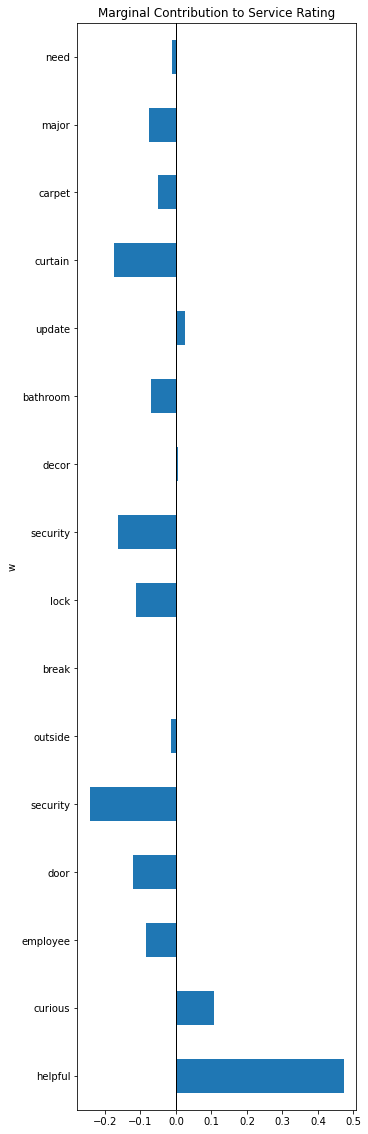

In [216]:
# Plot marginal effects
mfx[::-1].plot(y='mfx', x = 'w', kind = 'barh',legend = None, figsize = (5,20), title = 'Marginal Contribution to Service Rating')
plt.axvline(x = 0, color = 'black', linewidth = 1)

#### Marginal contribution of each word to predicted room quality

In [217]:
mfx = get_mfx(r.processed_review_filter, tokenizer, model_rooms, MAX_LEN=300)
mfx['abs_mfx'] = mfx.mfx.map(abs)
mfx['abs_rank'] = mfx.abs_mfx.rank(ascending = False)

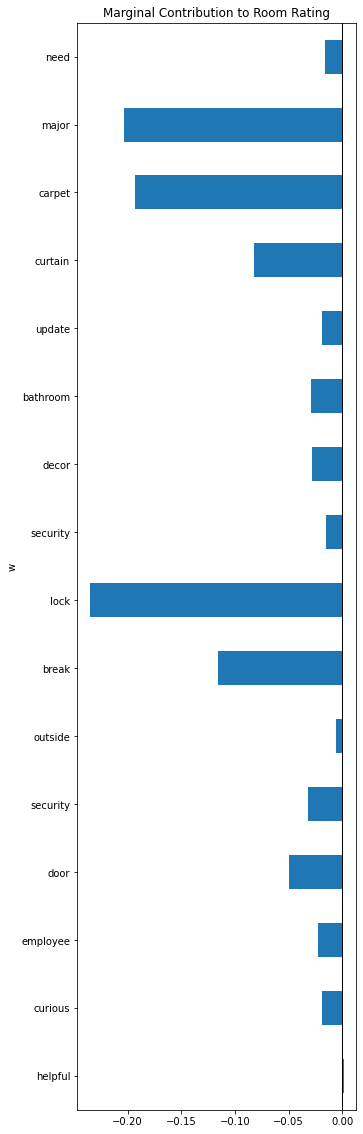

In [218]:
mfx[::-1].plot(y='mfx', x = 'w', kind = 'barh',legend = None, figsize = (5,20), title = 'Marginal Contribution to Room Rating')
plt.axvline(x = 0, color = 'black', linewidth = 1)